<a href="https://colab.research.google.com/github/Hussein-Qasem/Final-Course-All-files/blob/main/XGBoost_All_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go  # plotly ref https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Histogram.html
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder

from IPython.display import display, HTML


In [ ]:
#data = pd.read_csv("/content/drive/MyDrive/house prediction/Code/train.csv")
data = pd.read_csv('train.csv')
test = pd.read_csv('/content/test (1).csv')

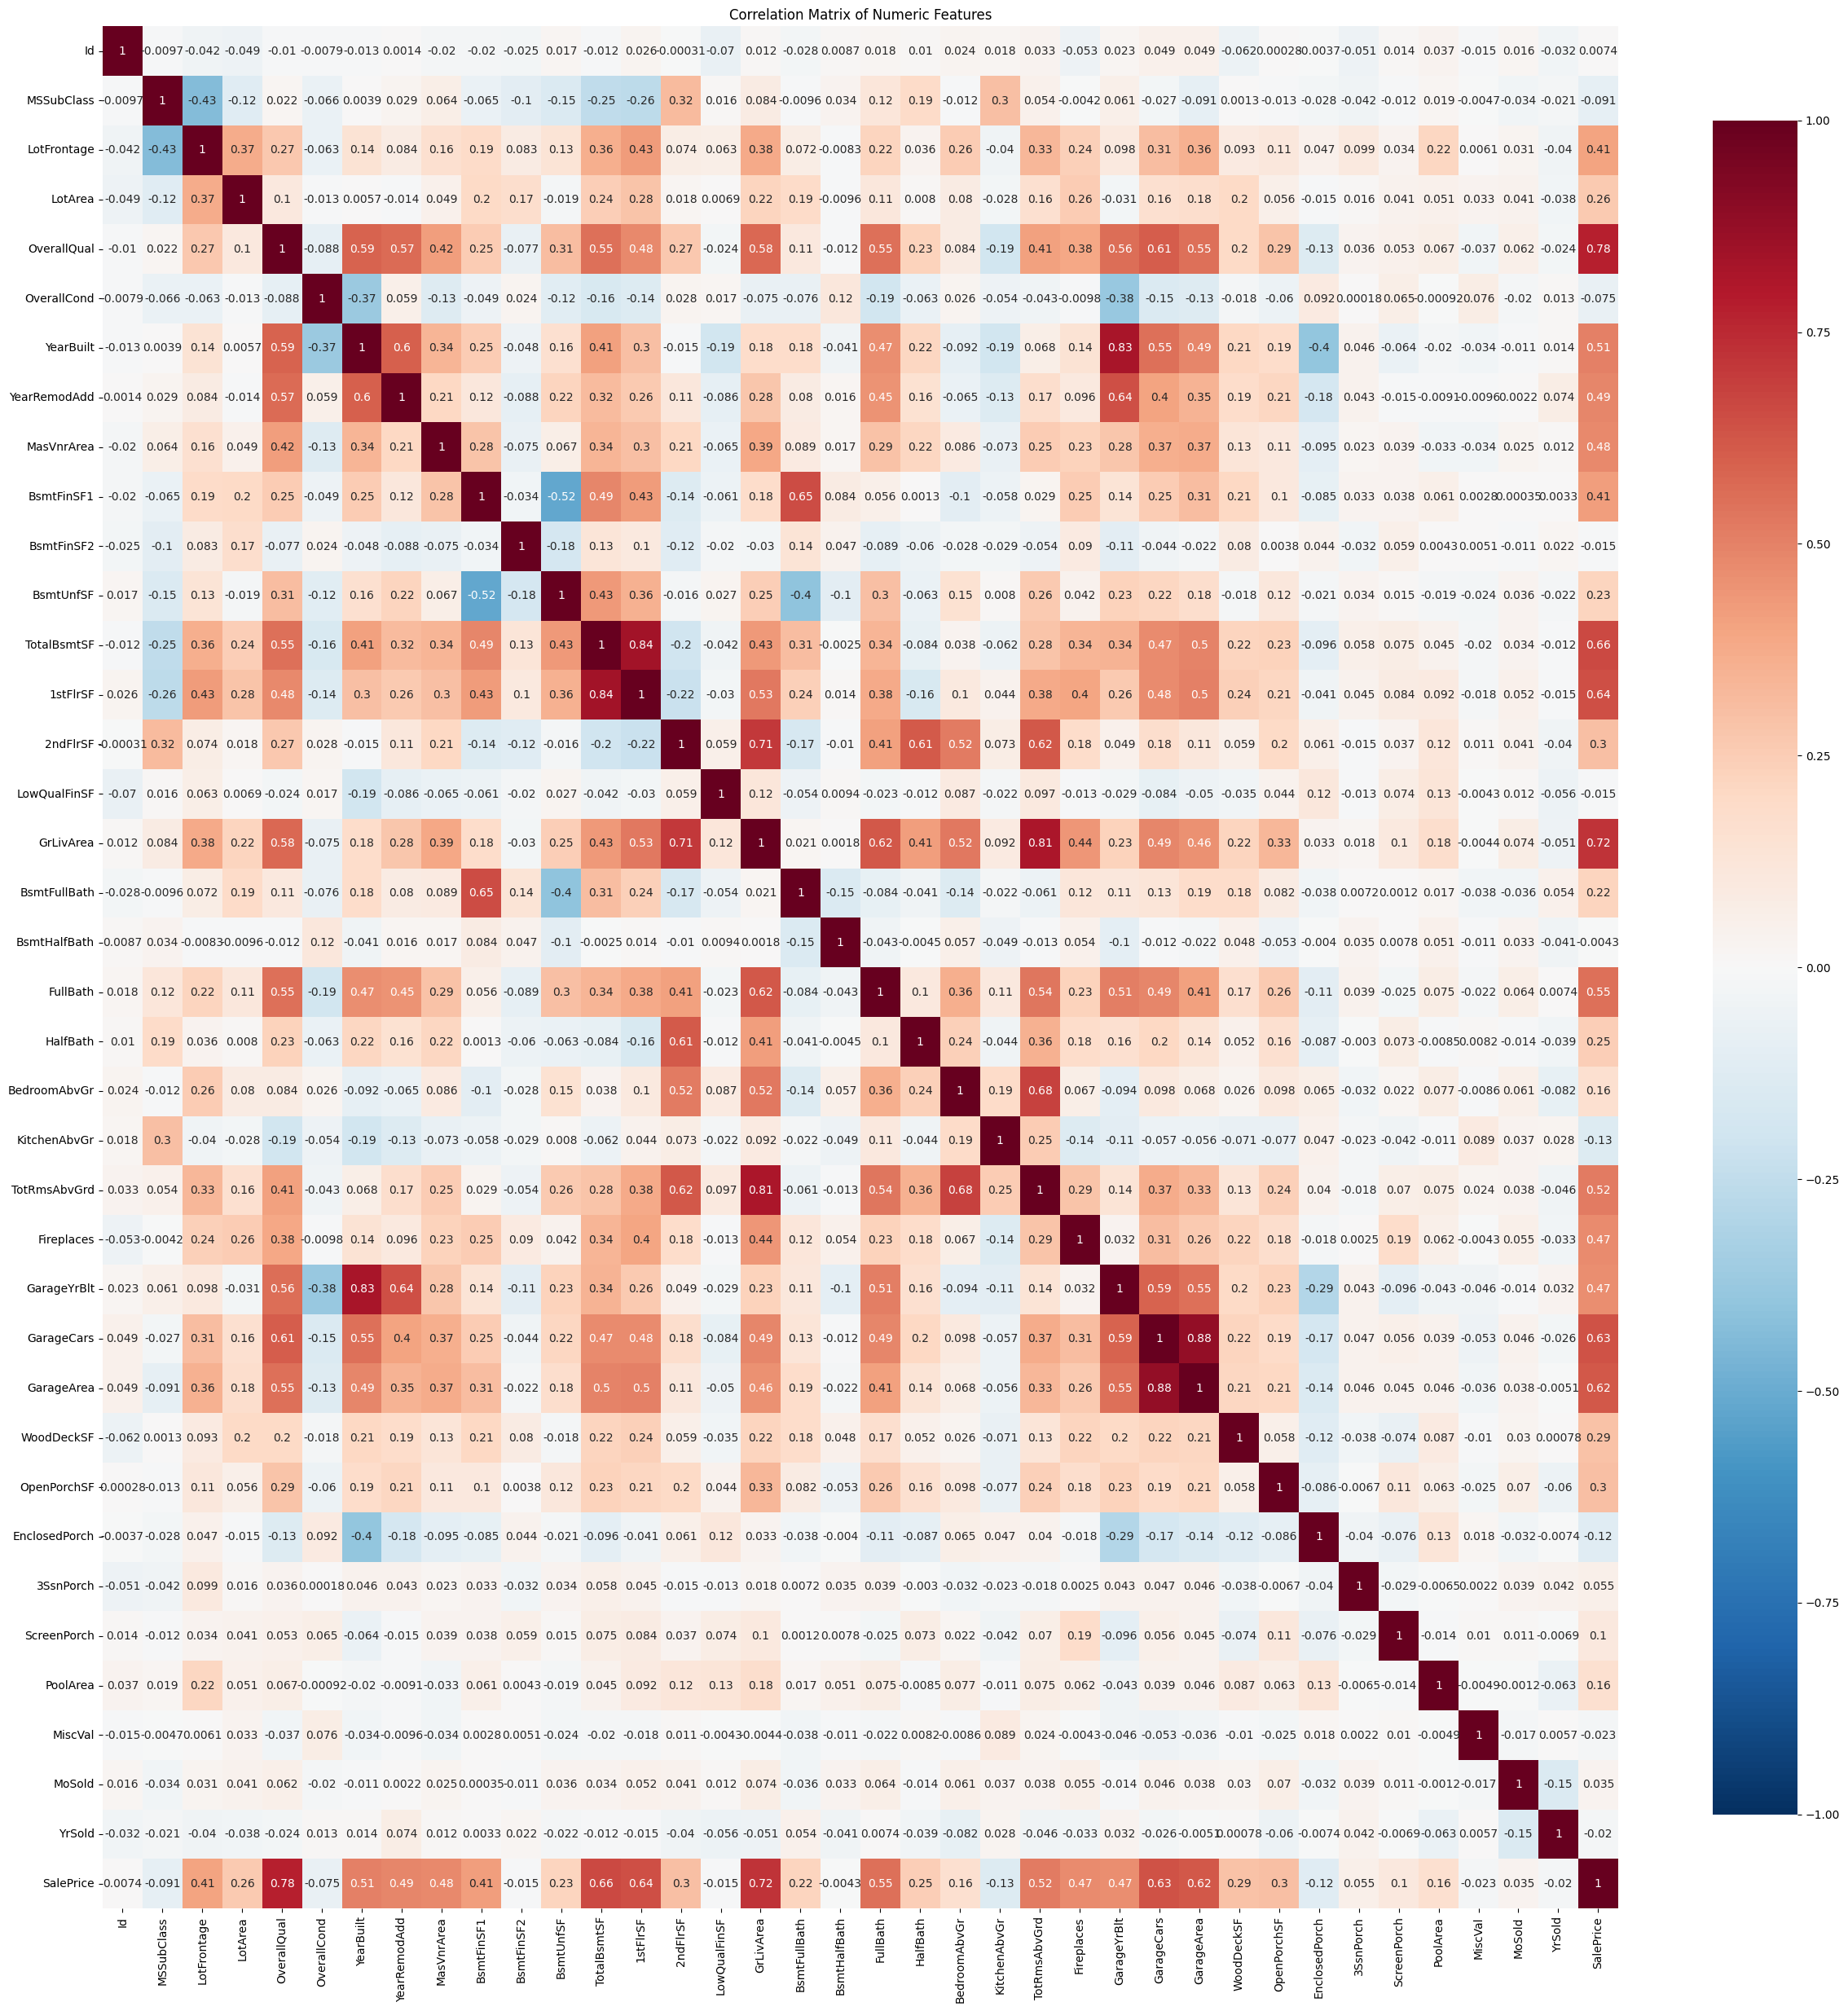

In [ ]:
# Correlation for numerical features
numerical_features = [col for col in data if data[col].dtype != object]

plt.figure(figsize=(30,30))
sns.heatmap(data[numerical_features].corr(), annot=True, cmap='RdBu_r', vmin=-1, vmax=1,cbar_kws={"shrink": 0.9} # Thinner color bar
            )
plt.title('Correlation Matrix of Numeric Features')
plt.show()



In [ ]:
pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 13.5 MB/s eta 0:00:00


In [ ]:
import dash
from dash import dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Assuming `data` is your DataFrame loaded previously
# data = pd.read_csv('your_data.csv')

numerical_features = [col for col in data if data[col].dtype != object]

# Compute the correlation matrix
corr_matrix = data[numerical_features].corr()

# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Correlation Matrix of Numeric Features'),
    dcc.Graph(
        id='correlation-heatmap',
        figure=px.imshow(
            corr_matrix,
            text_auto=True,
            color_continuous_scale='RdBu_r',
            zmin=-1,
            zmax=1
        ).update_layout(
            width=1300,
            height=1300
        )
    ),

    html.Div([
        html.Label('Select X feature'),
        dcc.Dropdown(
            id='x-feature',
            options=[{'label': col, 'value': col} for col in numerical_features],
            value=numerical_features[0]
        ),
    ], style={'width': '48%', 'display': 'inline-block'}),

    html.Div([
        html.Label('Select Y feature'),
        dcc.Dropdown(
            id='y-feature',
            options=[{'label': col, 'value': col} for col in numerical_features],
            value=numerical_features[1]
        ),
    ], style={'width': '48%', 'display': 'inline-block'}),

    dcc.Graph(id='selected-correlation')
])

@app.callback(
    Output('selected-correlation', 'figure'),
    [Input('x-feature', 'value'),
     Input('y-feature', 'value')]
)
def update_selected_correlation(x_feature, y_feature):
    corr_value = data[[x_feature, y_feature]].corr().iloc[0, 1]
    fig = go.Figure(data=go.Heatmap(
        z=[[corr_value]],
        x=[x_feature],
        y=[y_feature],
        colorscale='RdBu_r',
        zmin=-1,
        zmax=1,
        text=[[f'{corr_value:.2f}']],
        texttemplate="%{text}"
    ))
    fig.update_layout(
        title=f'Correlation between {x_feature} and {y_feature}',
        xaxis_title=x_feature,
        yaxis_title=y_feature,
        width=600,
        height=600
    )
    return fig

if __name__ == '__main__':
  app.run_server(debug=True)



<ipython-input-13-e6b4c61907ee>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<IPython.core.display.Javascript object>

In [ ]:

# Analysis of the numerical features
colors = [
    'brown', 'burlywood', 'hotpink', 'olive',  'teal', 'blue', 'orange', 'green', 'red', 'purple','black','yellow','gray','cyan','magenta','maroon','pink','lime','navy','silver','fuchsia','indigo','teal'
]

for i, col in enumerate(numerical_features):
    # Create the plot
    fig = go.Figure()

    # Plot the histogram of non-NaN values
    fig.add_trace(go.Histogram(x = data[col].dropna(), marker=dict(color=colors[i % len(colors)]),  # Use color names directly
        name='Non-NaN'
    ))

    # Add a bar for NaN values
    num_nans = data[col].isna().sum()
    if num_nans > 0:
        fig.add_trace(go.Bar(
            x=[data[col].min() - 1],  #The x-coordinate of the bar is set to a value smaller than the minimum value of the numerical feature
            y=[num_nans],
            marker=dict(color='blue'),
            name=f'NaN (count={num_nans})'
        ))

    # Update layout
    fig.update_layout(
        title=f"Distribution of {col} (including NaN values)",
        xaxis_title=col,
        yaxis_title='Count',
        bargap=0.2,
        xaxis=dict(tickangle=45),
        legend=dict(title='Legend'),
        width=700,
        height=400
    )

    # Summary statistics
    summary_stats = data[col].describe()
    summary_stats_html = summary_stats.to_frame().to_html()

    # Combine plot and summary statistics
    display(HTML(f"""
    <div style="display: flex; align-items: flex-start;">
        <div>{fig.to_html(full_html=False, include_plotlyjs='cdn')}</div>
        <div style="padding-left: 50px;">
            <h4>Summary Statistics for {col}</h4>
            {summary_stats_html}
            <p>Number of NaN values in {col}: {num_nans}</p>
        </div>
    </div>
    """))


Anova

In [ ]:
"""# ANOVA for the continuous variables with the target

import statsmodels.api as sm
from statsmodels.formula.api import ols
import re

# Select continuous features and target variable
target_variable = 'SalePrice'
continuous_features = [col for col in data.columns if col != target_variable and data[col].dtype != object]

# Function to sanitize column names
def sanitize_column_name(name):
    return re.sub(r'[^0-9a-zA-Z_]+', '_', name)

# Sanitize all column names in the DataFrame
data.columns = [sanitize_column_name(col) for col in data.columns]

# Perform ANOVA for each continuous feature with the target
for feature in continuous_features:
    sanitized_feature = sanitize_column_name(feature)

    # Fit the ANOVA model
    formula = f'{sanitize_column_name(target_variable)} ~ {sanitized_feature}'
    model = ols(formula, data=data.rename(columns={feature: sanitized_feature})).fit()

    # Extract the ANOVA table
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Print the ANOVA table for the current feature
    print(f'ANOVA table for {feature}:')
    print(anova_table.to_string())
    print()"""

SyntaxError: incomplete input (<ipython-input-15-05677252c636>, line 32)

In [ ]:
from scipy.stats import chi2_contingency

all_categorical_features = [col for col in data if data[col].dtype == object]
print('The features that seems to have a relationship with SalePrice are:')

for feature in all_categorical_features:
  # Create contingency table
  contingency_table = pd.crosstab(data[feature], data['SalePrice'])

  # Perform chi-square test
  chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table.values)

  # Print results
  if p_value < 0.05:
    print(f"  {feature} ")



The features that seems to have a relationship with SalePrice are:
  MSZoning 
  Street 
  LotShape 
  LandSlope 
  ExterQual 
  ExterCond 
  Foundation 
  BsmtQual 
  BsmtCond 
  BsmtExposure 
  Heating 
  HeatingQC 
  CentralAir 
  Electrical 
  KitchenQual 
  FireplaceQu 
  GarageFinish 
  SaleType 
  SaleCondition 


In [ ]:
# Get the number of categorical Variables

categorical_features = [col for col in data if data[col].dtype == object]
print(f"Number of categorical variables: {len(categorical_features)}")

Cat_var = [col for col in data if data[col].dtype == object]

# Calculate the number of rows needed, ensuring enough space for all plots
num_rows = (len(Cat_var) + 1) // 2

fig = make_subplots(rows=num_rows, cols=2, subplot_titles=Cat_var) # Adjust number of rows

for i, col in enumerate(Cat_var):
    row = (i // 2) + 1
    col_pos = (i % 2) + 1
    value_counts = data[col].value_counts()

    fig.add_trace(
        go.Bar(x=value_counts.index, y=value_counts.values, name=col),
        row=row, col=col_pos
    )

    fig.update_xaxes(tickangle=45, row=row, col=col_pos)

fig.update_layout(
    height=4000, width=1500,
    title_text="Categorical Variable Distributions",
    showlegend=False
)

fig.show()

Number of categorical variables: 43


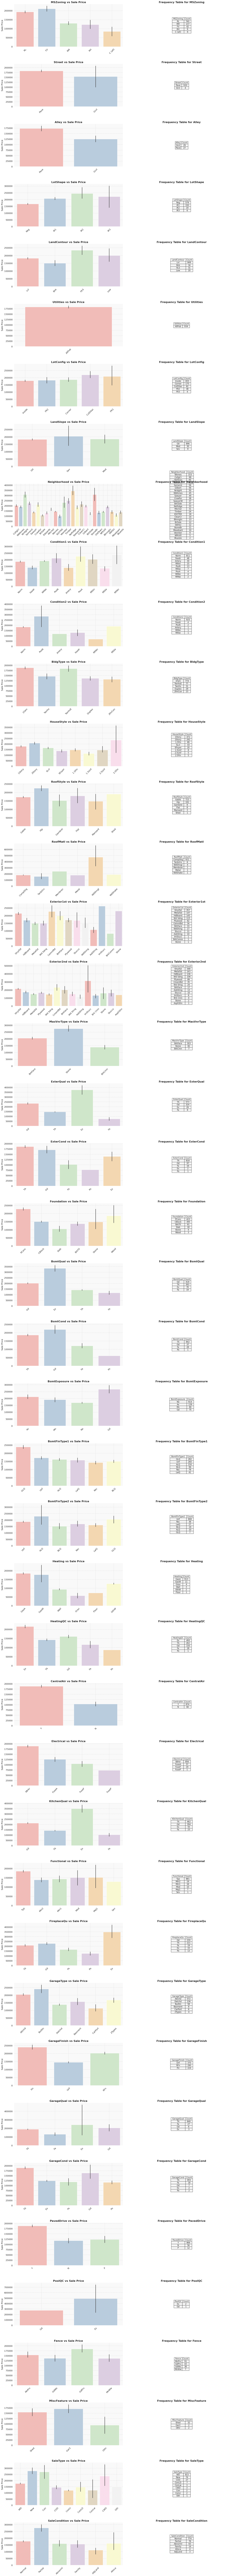

In [ ]:
# Bivariate anlaysis of the categorical variables with the target "Sales Price"


# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=len(Cat_var), ncols=2, figsize=(20, 5*len(Cat_var)))

# Loop through each categorical variable
for i, col in enumerate(Cat_var):
    # Frequency table
    freq_table = data[col].value_counts().reset_index()
    freq_table.columns = [col, 'Count']

    # Create a bar plot of the categorical variable against the target variable
    sns.barplot(x=col, y='SalePrice', data=data, ax=axes[i, 0], hue=col,palette="Pastel1", dodge=False)
    axes[i, 0].set_title(f'{col} vs Sale Price', fontsize=16, weight='bold')
    axes[i, 0].set_ylabel('Sale Price', fontsize=14)
    axes[i, 0].set_xlabel('')
    axes[i, 0].tick_params(axis='x', rotation=45)
    sns.despine(left=True, bottom=True)

    # Improve grid lines and background
    axes[i, 0].grid(True, which='both', linestyle='--', linewidth=0.7)
    axes[i, 0].set_facecolor('#f9f9f9')

    # Remove the legend if it exists
    if axes[i, 0].legend_ is not None:
        axes[i, 0].legend_.remove()

    # Create a frequency table
    axes[i, 1].axis('off')
    table = axes[i, 1].table(cellText=freq_table.values,
                             colLabels=freq_table.columns,
                             cellLoc='center',
                             loc='center',
                             cellColours=[['#f5f5f5']*len(freq_table.columns)]*len(freq_table))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    table.auto_set_column_width(col=list(range(len(freq_table.columns))))
    axes[i, 1].set_title(f'Frequency Table for {col}', fontsize=16, weight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Missing Values
def missing_values(data):
  # Getting the number of missing values in each column
  num_missing = data.isna().sum()
  # Excluding columns that contains 0 missing values
  num_missing = num_missing[num_missing > 0]
  # Getting the percentages of missing values
  percent_missing = num_missing * 100 / data.shape[0]
  # Concatenating the number and perecentage of missing values
  # into one dataframe and sorting it
  pd.concat([num_missing, percent_missing], axis=1,
            keys=['Missing Values', 'Percentage']).\
            sort_values(by="Missing Values", ascending=False)
  return data

In [ ]:
missing_values(data)
missing_values(test)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0      42          20       RL        115.0    16905   Pave   NaN      Reg   
1    1156          20       RL         90.0    10768   Pave   NaN      IR1   
2     239          20       RL         93.0    12030   Pave   NaN      Reg   
3     810          75       RM         90.0     8100   Pave   NaN      Reg   
4     471         120       RL          NaN     6820   Pave   NaN      IR1   
..    ...         ...      ...          ...      ...    ...   ...      ...   
229   389          20       RL         93.0     9382   Pave   NaN      IR1   
230  1193          50       RM         60.0     9600   Pave  Grvl      Reg   
231    95          60       RL         69.0     9337   Pave   NaN      IR1   
232  1171          80       RL         76.0     9880   Pave   NaN      Reg   
233   190         120       RL         41.0     4923   Pave   NaN      Reg   

    LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0           Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
1           Lvl    AllPub  ...         180        0    NaN    NaN         NaN   
2           Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
3           Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
4           Lvl    AllPub  ...         140        0    NaN    NaN         NaN   
..          ...       ...  ...         ...      ...    ...    ...         ...   
229         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
230         Lvl    AllPub  ...           0        0    NaN   GdWo         NaN   
231         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
232         Lvl    AllPub  ...           0      576     Gd  GdPrv         NaN   
233         Lvl    AllPub  ...         224        0    NaN    NaN         NaN   

    MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         0      7    2007        WD         Normal  
1         0      7    2007        WD         Normal  
2         0     12    2007       New        Partial  
3         0     11    2009        WD         Normal  
4         0      6    2010        WD         Normal  
..      ...    ...     ...       ...            ...  
229       0      7    2008        WD         Normal  
230       0      7    2007        WD         Normal  
231       0      5    2007        WD         Normal  
232       0      7    2008        WD         Normal  
233       0      8    2008        WD         Normal  

[234 rows x 80 columns]

In [ ]:
def fill_missing_values(data):
  # Filling Null Values
  data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
  data['MasVnrType'] = data['MasVnrType'].fillna('None')
  data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
  data[['BsmtQual', 'BsmtCond']] = data[['BsmtQual', 'BsmtCond']].fillna('NA')
  data['BsmtExposure'] = data['BsmtExposure'].fillna('No')
  data['BsmtFinType1'] = data['BsmtFinType1'].fillna('NA')
  data['Electrical'].fillna(data['Electrical'].mode()[0], inplace=True)

  data['GarageYrBlt'].fillna(0, inplace=True)

  # Impute missing values in GarageFinish with placeholder category 'None'
  data['GarageFinish'].fillna('NA', inplace=True)
  data['FireplaceQu'].fillna('NA', inplace=True)


  # Create the TotalBath feature
  data['TotalBath'] = data['FullBath'] + data['HalfBath'] + data['BsmtFullBath'] + data['BsmtHalfBath']  # Correlation with SalePrice is 0.59

  return data

fill_missing_values(data)
fill_missing_values(test)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0      42          20       RL        115.0    16905   Pave   NaN      Reg   
1    1156          20       RL         90.0    10768   Pave   NaN      IR1   
2     239          20       RL         93.0    12030   Pave   NaN      Reg   
3     810          75       RM         90.0     8100   Pave   NaN      Reg   
4     471         120       RL         47.0     6820   Pave   NaN      IR1   
..    ...         ...      ...          ...      ...    ...   ...      ...   
229   389          20       RL         93.0     9382   Pave   NaN      IR1   
230  1193          50       RM         60.0     9600   Pave  Grvl      Reg   
231    95          60       RL         69.0     9337   Pave   NaN      IR1   
232  1171          80       RL         76.0     9880   Pave   NaN      Reg   
233   190         120       RL         41.0     4923   Pave   NaN      Reg   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0           Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1           Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2           Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3           Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
4           Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
..          ...       ...  ...      ...    ...    ...         ...     ...   
229         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
230         Lvl    AllPub  ...        0    NaN   GdWo         NaN       0   
231         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
232         Lvl    AllPub  ...      576     Gd  GdPrv         NaN       0   
233         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  TotalBath  
0        7   2007        WD         Normal          3  
1        7   2007        WD         Normal          3  
2       12   2007       New        Partial          2  
3       11   2009        WD         Normal          2  
4        6   2010        WD         Normal          3  
..     ...    ...       ...            ...        ...  
229      7   2008        WD         Normal          2  
230      7   2007        WD         Normal          1  
231      5   2007        WD         Normal          4  
232      7   2008        WD         Normal          2  
233      8   2008        WD         Normal          3  

[234 rows x 81 columns]

In [ ]:
# Standardization
def standardization(data):
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()

  data['LotArea'] = scaler.fit_transform(data[['LotArea']])
  data[['MasVnrArea', 'TotalBsmtSF']] = scaler.fit_transform(data[['MasVnrArea', 'TotalBsmtSF']])

  data['TotalBath'] = scaler.fit_transform(data[['TotalBath']])


  # data['GarageYrBlt'] = scaler.fit_transform(data[['GarageYrBlt']]) #### Verify
  current_year = 2024
  data['GarageAge'] = current_year - data['GarageYrBlt'] ###
  data['GarageAge'] = data['GarageAge'].replace(current_year, 0)###
  data['GarageAge'] = scaler.fit_transform(data[['GarageAge']])###
  data['GarageYrBlt'].drop(columns=['GarageYrBlt'],inplace=True) ###

  data["HouseAge"] = data["YrSold"] - data["YearBuilt"]

  data['1stFlrSF'] = scaler.fit_transform(data[['1stFlrSF']])
  data['2ndFlrSF'] = scaler.fit_transform(data[['2ndFlrSF']])
  data['GrLivArea'] = scaler.fit_transform(data[['GrLivArea']])
  data['GarageArea'] = scaler.fit_transform(data[['GarageArea']])

  data['GarageArea'] = scaler.fit_transform(data[['GarageArea']])

  return data

standardization(data)
standardization(test)

Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0      42          20       RL        115.0  0.529078   Pave   NaN      Reg   
1    1156          20       RL         90.0 -0.004676   Pave   NaN      IR1   
2     239          20       RL         93.0  0.105084   Pave   NaN      Reg   
3     810          75       RM         90.0 -0.236721   Pave   NaN      Reg   
4     471         120       RL         47.0 -0.348047   Pave   NaN      IR1   
..    ...         ...      ...          ...       ...    ...   ...      ...   
229   389          20       RL         93.0 -0.125221   Pave   NaN      IR1   
230  1193          50       RM         60.0 -0.106261   Pave  Grvl      Reg   
231    95          60       RL         69.0 -0.129135   Pave   NaN      IR1   
232  1171          80       RL         76.0 -0.081909   Pave   NaN      Reg   
233   190         120       RL         41.0 -0.513035   Pave   NaN      Reg   

    LandContour Utilities  ...  Fence MiscFeature MiscVal MoSold YrSold  \
0           Lvl    AllPub  ...    NaN         NaN       0      7   2007   
1           Lvl    AllPub  ...    NaN         NaN       0      7   2007   
2           Lvl    AllPub  ...    NaN         NaN       0     12   2007   
3           Lvl    AllPub  ...  MnPrv         NaN       0     11   2009   
4           Lvl    AllPub  ...    NaN         NaN       0      6   2010   
..          ...       ...  ...    ...         ...     ...    ...    ...   
229         Lvl    AllPub  ...    NaN         NaN       0      7   2008   
230         Lvl    AllPub  ...   GdWo         NaN       0      7   2007   
231         Lvl    AllPub  ...    NaN         NaN       0      5   2007   
232         Lvl    AllPub  ...  GdPrv         NaN       0      7   2008   
233         Lvl    AllPub  ...    NaN         NaN       0      8   2008   

    SaleType SaleCondition  TotalBath  GarageAge  HouseAge  
0         WD        Normal   0.680074   0.776520        48  
1         WD        Normal   0.680074   0.170597        31  
2        New       Partial  -0.395178  -0.934322         0  
3         WD        Normal  -0.395178   2.523004       111  
4         WD        Normal   0.680074  -0.150186        25  
..       ...           ...        ...        ...       ...  
229       WD        Normal  -0.395178  -0.649182         9  
230       WD        Normal  -1.470429   1.988366        82  
231       WD        Normal   1.755325  -0.577897        10  
232       WD        Normal  -0.395178   0.134954        31  
233       WD        Normal   0.680074  -0.720467         7  

[234 rows x 83 columns]

In [ ]:
"""data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')"""

"data = pd.read_csv('train.csv')\ntest = pd.read_csv('test.csv')"

In [ ]:
# Drop Columns
def drop_columns(data):
  #Drop Alley because there were 878 null value after mapping the values and filling the null values the correlation with SalePrice was very low
  data.drop('Alley', axis=1, inplace=True)

  #Drop OverallCond because the correlation with the price were very low = 0.075
  data.drop('OverallCond', axis=1, inplace=True)

  #Drop YearRemodAdd because the correlation with all the variables is similar to the correlation between YearBuilt and the other variables
  data.drop('YearRemodAdd', axis=1, inplace=True)

  #Drop YearBuilt because we created a new column which is HouseAge
  data.drop('YearBuilt', axis=1, inplace=True)

  # Drop RoofMatl Columns because it has one major class and all prices with the other materials aren't different
  data.drop('RoofMatl', axis=1, inplace=True)

  # Drop BsmtFinSF1, BsmtFinType2, BsmtFinSF2 and BsmtUnfSF columns
  data.drop(['BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1, inplace=True)

  # Drop Heating column because it has one major class and all prices with the other materials aren't different
  data.drop('Heating', axis=1, inplace=True)

  # Drop the original individual columns
  data.drop(columns=['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], inplace=True)

  data.drop(['LowQualFinSF','BedroomAbvGr','GarageType','KitchenAbvGr'], axis=1, inplace=True)

  # Create a binary feature indicating whether functionality is typical or not
  data['Functional_Typical'] = (data['Functional'] == 'Typ').astype(int)

  # Drop the original 'Functional' column
  data.drop(columns=['Functional'],axis=1, inplace=True)


  # Drop these columns becouse their majority data are null
  data.drop(['PoolQC','Fence','MiscFeature'], axis=1, inplace=True)

  # Drop because of the distribution
  data.drop(['ScreenPorch', 'GarageQual','GarageCond', 'MiscVal','MoSold','YrSold'], axis=1, inplace=True)

  # Drop PoolArea because there are just 3 samples with values not zeroes
  data.drop('PoolArea', axis=1, inplace=True)

  return data




In [ ]:
drop_columns(data)
drop_columns(test)

Id  MSSubClass MSZoning  LotFrontage   LotArea Street LotShape  \
0      42          20       RL        115.0  0.529078   Pave      Reg   
1    1156          20       RL         90.0 -0.004676   Pave      IR1   
2     239          20       RL         93.0  0.105084   Pave      Reg   
3     810          75       RM         90.0 -0.236721   Pave      Reg   
4     471         120       RL         47.0 -0.348047   Pave      IR1   
..    ...         ...      ...          ...       ...    ...      ...   
229   389          20       RL         93.0 -0.125221   Pave      IR1   
230  1193          50       RM         60.0 -0.106261   Pave      Reg   
231    95          60       RL         69.0 -0.129135   Pave      IR1   
232  1171          80       RL         76.0 -0.081909   Pave      Reg   
233   190         120       RL         41.0 -0.513035   Pave      Reg   

    LandContour Utilities LotConfig  ... WoodDeckSF OpenPorchSF EnclosedPorch  \
0           Lvl    AllPub    Inside  ...          0         104             0   
1           Lvl    AllPub    Corner  ...          0          21             0   
2           Lvl    AllPub    Inside  ...        168         228             0   
3           Lvl    AllPub    Corner  ...         40         156             0   
4           Lvl    AllPub    Corner  ...          0          54             0   
..          ...       ...       ...  ...        ...         ...           ...   
229         Lvl    AllPub   CulDSac  ...        120          25             0   
230         Lvl    AllPub    Inside  ...          0           0            84   
231         Lvl    AllPub    Inside  ...          0         162             0   
232         Lvl    AllPub    Inside  ...        203           0             0   
233         Lvl    AllPub    Inside  ...          0         120             0   

    3SsnPorch SaleType SaleCondition  TotalBath GarageAge HouseAge  \
0           0       WD        Normal   0.680074  0.776520       48   
1           0       WD        Normal   0.680074  0.170597       31   
2           0      New       Partial  -0.395178 -0.934322        0   
3           0       WD        Normal  -0.395178  2.523004      111   
4           0       WD        Normal   0.680074 -0.150186       25   
..        ...      ...           ...        ...       ...      ...   
229         0       WD        Normal  -0.395178 -0.649182        9   
230         0       WD        Normal  -1.470429  1.988366       82   
231         0       WD        Normal   1.755325 -0.577897       10   
232         0       WD        Normal  -0.395178  0.134954       31   
233         0       WD        Normal   0.680074 -0.720467        7   

    Functional_Typical  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
..                 ...  
229                  1  
230                  1  
231                  1  
232                  1  
233                  1  

[234 rows x 55 columns]

In [ ]:
# Encoding
def encoding_data(data):
  # Ordinal Encoding
  data['Street']  = data['Street'].map({'Grvl':0,'Pave':1})
  data['LotShape'] = data['LotShape'].map({'Reg':3,'IR1': 2,'IR2': 1,'IR3': 0})
  data['Utilities'] = data['Utilities'].map({'AllPub': 3,'NoSewr': 2,'NoSeWa': 1, 'ELO': 0})
  data['LandSlope'] = data['LandSlope'].map({'Gtl': 2,'Mod': 1,'Sev': 0})
  data['LotConfig'] = data['LotConfig'].replace(['FR2', 'FR3'], 'FR2_3')
  data['BldgType'] = data['BldgType'].replace(['2fmCon', 'Duplex'], '2dwelling')


  mp = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0}
  data['ExterQual'] = data['ExterQual'].map(mp)
  data['ExterCond'] = data['ExterCond'].map(mp)
  data['MasVnrType'] = data['MasVnrType'].map({'None': 0, 'CBlock': 1, 'BrkCmn': 2, 'BrkFace': 3, 'Stone': 4})
  mp2 = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
  data['BsmtQual'] = data['BsmtQual'].map(mp2)
  data['BsmtCond'] = data['BsmtCond'].map(mp2)
  data['BsmtExposure'] = data['BsmtExposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'NA':0})
  data['BsmtFinType1'] = data['BsmtFinType1'].map({'GLQ': 5, 'ALQ':4, 'BLQ': 3, 'LwQ':3, 'Rec': 3, 'Unf': 3, 'NA': 0 }) # Verify
  data['HeatingQC'] = data['HeatingQC'].map(mp)
  data['CentralAir'] = data['CentralAir'].map({'Y':1,'N':0})
  data['Electrical'] = data['Electrical'].map({'SBrkr':4,'FuseA':3,'FuseF':2,'FuseP':1,'Mix':2.5})

  ordinal_mapping = {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
  data['GarageFinish'] = data['GarageFinish'].map(ordinal_mapping)
  data['KitchenQual'] = data['KitchenQual'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po':0})
  data['FireplaceQu'] = data['FireplaceQu'].map({'Ex':5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})

  data['PavedDrive'] = data['PavedDrive'].map({'Y': 2, 'P': 1, 'N': 0})

  # Transform WoodDeckSF to binary feature
  data['WoodDeckSF_binary'] = data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
  data.drop('WoodDeckSF', axis=1, inplace=True)

  # Transform OpenPorchSF to binary feature
  data['OpenPorchSF_binary'] = data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
  data.drop('OpenPorchSF', axis=1, inplace=True)

  # Transform EnclosedPorch to binary feature
  data['EnclosedPorch_binary'] = data['EnclosedPorch'].apply(lambda x: 1 if x > 0 else 0)
  data.drop('EnclosedPorch', axis=1, inplace=True)


  # Create binary variable for 3SsnPorch
  data['3SsnPorch_binary'] = data['3SsnPorch'].apply(lambda x: 0 if x == 0 else 1)
  data.drop('3SsnPorch', axis=1, inplace=True)


  # Label Encoding for SaleType
  label_encoder = LabelEncoder()
  data['SaleTypeEncoded'] = label_encoder.fit_transform(data['SaleType'])

  # Convert encoded values to binary (0 or 1)
  data['SaleTypeBinary'] = (data['SaleTypeEncoded'] >=0.1).astype(int)

  # Drop the original 'SaleType' column
  data.drop(columns=['SaleType', 'SaleTypeEncoded'], inplace=True)


  # Onehot Encoding
  data = pd.get_dummies(data, columns=['MSZoning','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
                                       'HouseStyle','Exterior1st', 'Exterior2nd','RoofStyle', 'Foundation', 'SaleCondition'],drop_first=False)

  return data


In [ ]:
encoding_data(data)
encoding_data(test)

Id  MSSubClass  LotFrontage   LotArea  Street  LotShape  Utilities  \
0      42          20        115.0  0.529078       1         3          3   
1    1156          20         90.0 -0.004676       1         2          3   
2     239          20         93.0  0.105084       1         3          3   
3     810          75         90.0 -0.236721       1         3          3   
4     471         120         47.0 -0.348047       1         2          3   
..    ...         ...          ...       ...     ...       ...        ...   
229   389          20         93.0 -0.125221       1         2          3   
230  1193          50         60.0 -0.106261       1         3          3   
231    95          60         69.0 -0.129135       1         2          3   
232  1171          80         76.0 -0.081909       1         3          3   
233   190         120         41.0 -0.513035       1         3          3   

     LandSlope  OverallQual  MasVnrType  ...  Foundation_CBlock  \
0            2            5           0  ...               True   
1            2            5           0  ...               True   
2            2            8           3  ...              False   
3            2            5           0  ...              False   
4            2            8           0  ...              False   
..         ...          ...         ...  ...                ...   
229          2            7           3  ...              False   
230          2            5           0  ...              False   
231          2            6           0  ...              False   
232          2            6           0  ...               True   
233          2            8           0  ...              False   

     Foundation_PConc  Foundation_Slab  Foundation_Stone  \
0               False            False             False   
1               False            False             False   
2                True            False             False   
3                True            False             False   
4                True            False             False   
..                ...              ...               ...   
229              True            False             False   
230              True            False             False   
231              True            False             False   
232             False            False             False   
233              True            False             False   

     SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                    False                  False                 False   
1                    False                  False                 False   
2                    False                  False                 False   
3                    False                  False                 False   
4                    False                  False                 False   
..                     ...                    ...                   ...   
229                  False                  False                 False   
230                  False                  False                 False   
231                  False                  False                 False   
232                  False                  False                 False   
233                  False                  False                 False   

     SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                   False                  True                  False  
1                   False                  True                  False  
2                   False                 False                   True  
3                   False                  True                  False  
4                   False                  True                  False  
..                    ...                   ...                    ...  
229                 False                  True                  False  
230                 False                  True                  False 

In [ ]:
# Getting the number of missing values in each column
def missing_values(data):
  num_missing = data.isna().sum()
  # Excluding columns that contains 0 missing values
  num_missing = num_missing[num_missing > 0]
  # Getting the percentages of missing values
  percent_missing = num_missing * 100 / data.shape[0]
  # Concatenating the number and perecentage of missing values
  # into one dataframe and sorting it
  pd.concat([num_missing, percent_missing], axis=1,
            keys=['Missing Values', 'Percentage']).\
            sort_values(by="Missing Values", ascending=False)
  return data

missing_values(data)
missing_values(test)

Id  MSSubClass MSZoning  LotFrontage   LotArea  Street  LotShape  \
0      42          20       RL        115.0  0.529078       1         3   
1    1156          20       RL         90.0 -0.004676       1         2   
2     239          20       RL         93.0  0.105084       1         3   
3     810          75       RM         90.0 -0.236721       1         3   
4     471         120       RL         47.0 -0.348047       1         2   
..    ...         ...      ...          ...       ...     ...       ...   
229   389          20       RL         93.0 -0.125221       1         2   
230  1193          50       RM         60.0 -0.106261       1         3   
231    95          60       RL         69.0 -0.129135       1         2   
232  1171          80       RL         76.0 -0.081909       1         3   
233   190         120       RL         41.0 -0.513035       1         3   

    LandContour  Utilities LotConfig  ...  SaleCondition TotalBath GarageAge  \
0           Lvl          3    Inside  ...         Normal  0.680074  0.776520   
1           Lvl          3    Corner  ...         Normal  0.680074  0.170597   
2           Lvl          3    Inside  ...        Partial -0.395178 -0.934322   
3           Lvl          3    Corner  ...         Normal -0.395178  2.523004   
4           Lvl          3    Corner  ...         Normal  0.680074 -0.150186   
..          ...        ...       ...  ...            ...       ...       ...   
229         Lvl          3   CulDSac  ...         Normal -0.395178 -0.649182   
230         Lvl          3    Inside  ...         Normal -1.470429  1.988366   
231         Lvl          3    Inside  ...         Normal  1.755325 -0.577897   
232         Lvl          3    Inside  ...         Normal -0.395178  0.134954   
233         Lvl          3    Inside  ...         Normal  0.680074 -0.720467   

    HouseAge Functional_Typical WoodDeckSF_binary  OpenPorchSF_binary  \
0         48                  1                 0                   1   
1         31                  1                 0                   1   
2          0                  1                 1                   1   
3        111                  1                 1                   1   
4         25                  1                 0                   1   
..       ...                ...               ...                 ...   
229        9                  1                 1                   1   
230       82                  1                 0                   0   
231       10                  1                 0                   1   
232       31                  1                 1                   0   
233        7                  1                 0                   1   

    EnclosedPorch_binary 3SsnPorch_binary SaleTypeBinary  
0                      0                0              1  
1                      0                0              1  
2                      0                0              1  
3                      0                0              1  
4                      0                0              1  
..                   ...              ...            ...  
229                    0                0              1  
230                    1                0              1  
231                    0                0              1  
232                    0                0              1  
233                    0                0              1  

[234 rows x 55 columns]

In [ ]:

data.drop(['MSZoning','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
                                       'HouseStyle','Exterior1st', 'Exterior2nd','RoofStyle', 'Foundation', 'SaleCondition'],axis=1,inplace=True)
test.drop(['MSZoning','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
                                       'HouseStyle','Exterior1st', 'Exterior2nd','RoofStyle', 'Foundation', 'SaleCondition'],axis=1,inplace=True)

In [ ]:
data.select_dtypes(include=[object])

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[934 rows x 0 columns]

In [ ]:
# Number of null values
data.isnull().sum()

Id                      0
MSSubClass              0
LotFrontage             0
LotArea                 0
Street                  0
LotShape                0
Utilities               0
LandSlope               0
OverallQual             0
MasVnrType              0
MasVnrArea              0
ExterQual               0
ExterCond               0
BsmtQual                0
BsmtCond                0
BsmtExposure            0
BsmtFinType1            0
TotalBsmtSF             0
HeatingQC               0
CentralAir              0
Electrical              0
1stFlrSF                0
2ndFlrSF                0
GrLivArea               0
KitchenQual             0
TotRmsAbvGrd            0
Fireplaces              0
FireplaceQu             0
GarageYrBlt             0
GarageFinish            0
GarageCars              0
GarageArea              0
PavedDrive              0
SalePrice               0
TotalBath               0
GarageAge               0
HouseAge                0
Functional_Typical      0
WoodDeckSF_b

In [ ]:
# Import linear regression model
from sklearn.linear_model import LinearRegression
# Separate the features and the target
X_train = data.drop(['Id','SalePrice'], axis=1)
y_train = data['SalePrice']

# Building the regression model
lnr = LinearRegression()
lnr.fit(X_train, y_train)


# Print the coefficients and intercept
print('Coefficients:', lnr.coef_)
print('Intercept:', lnr.intercept_)

# Calculate the mean squeare error
from sklearn.metrics import mean_squared_error
y_pred = lnr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)

"""
y_pred = lnr.predict(test_data)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': y_pred})
submission.to_csv('submission.csv', index=False)
"""



Coefficients: [-1.39418635e+02  4.66000043e+01  4.28818125e+03  2.91319344e+04
 -2.25741220e+03 -5.25687938e-10  1.17137818e+03  1.14252325e+04
 -3.17721971e+03  8.20268093e+03  1.21969109e+04 -2.35255320e+03
  6.81550774e+03 -1.21533039e+04  7.00420118e+03  3.21503325e+03
  8.64159713e+03  1.14672760e+03  6.77787020e+03 -2.69171764e+03
  1.29745276e+04  1.29701823e+04  9.43679849e+03  1.45539609e+04
 -4.36572693e+02  1.16890727e+04 -1.43193087e+03 -1.46169080e+01
  2.38898030e+03  2.34565721e+03  7.49947853e+03  1.83810673e+03
  3.24489703e+03  3.33178041e+03 -1.76027173e+01  1.17714026e+04
 -5.35616364e+02 -1.54750980e+03 -5.49138038e+03  1.06914672e+04
  9.62833866e+03]
Intercept: 27187.9412371277
Root Mean Squared Error: 32595.567405780897


"\ny_pred = lnr.predict(test_data)\nmse = mean_squared_error(y_test, y_pred)\nprint('Mean Squared Error:', mse)\n\nsubmission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': y_pred})\nsubmission.to_csv('submission.csv', index=False)\n"

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

# Separate the features and the target
X_train = data.drop(['Id', 'SalePrice'], axis=1)
y_train = data['SalePrice']

# Function to train model and print RMSE
def train_and_evaluate(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# Linear Regression
lnr = LinearRegression()
lnr_rmse = train_and_evaluate(lnr, X_train, y_train)
print('Linear Regression Root Mean Squared Error:', lnr_rmse)

# KNN
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn_rmse = train_and_evaluate(knn, X_train, y_train)
print('KNN Root Mean Squared Error:', knn_rmse)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rmse = train_and_evaluate(rf, X_train, y_train)
print('Random Forest Root Mean Squared Error:', rf_rmse)

# LightGBM
lgbm = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgbm_rmse = train_and_evaluate(lgbm, X_train, y_train)
print('LightGBM Root Mean Squared Error:', lgbm_rmse)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_rmse = train_and_evaluate(xgb_model, X_train, y_train)
print('XGBoost Root Mean Squared Error:', xgb_rmse)

# CatBoost
catboost_model = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
catboost_rmse = train_and_evaluate(catboost_model, X_train, y_train)
print('CatBoost Root Mean Squared Error:', catboost_rmse)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_rmse = train_and_evaluate(gb, X_train, y_train)
print('Gradient Boosting Root Mean Squared Error:', gb_rmse)



Linear Regression Root Mean Squared Error: 32595.567405780897
KNN Root Mean Squared Error: 41072.14508063842
Random Forest Root Mean Squared Error: 12482.671320341946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 38
[LightGBM] [Info] Start training from score 182981.457173
LightGBM Root Mean Squared Error: 14785.460453295864
XGBoost Root Mean Squared Error: 858.2636047967451
CatBoost Root Mean Squared Error: 9112.938767934922
Gradient Boosting Root Mean Squared Error: 14505.216882755833


In [ ]:

"""y_pred = lnr.predict(test.drop(['Id'], axis=1))


lnr = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_pred})
lnr.to_csv('lnr.csv', index=False)
"""

y_pred = knn.predict(test.drop(['Id'], axis=1))


knn = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_pred})
knn.to_csv('knn.csv', index=False)


y_pred = rf.predict(test.drop(['Id'], axis=1))


rf = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_pred})
rf.to_csv('rf.csv', index=False)

y_pred = lgbm.predict(test.drop(['Id'], axis=1))


lgbm = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_pred})
lgbm.to_csv('lgbm.csv', index=False)



"""

# Function to train model and print RMSE
def train_and_evaluate(model, test_data, y_pred):
    model.fit(X_train, y_train)
    y_pred = model.predict(test_data)
    mse = mean_squared_error(test_data, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# Linear Regression
lnr = LinearRegression()
lnr_rmse = train_and_evaluate(lnr, X_train, y_train)
print('Linear Regression Root Mean Squared Error:', lnr_rmse)

# KNN
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn_rmse = train_and_evaluate(knn, X_train, y_train)
print('KNN Root Mean Squared Error:', knn_rmse)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rmse = train_and_evaluate(rf, X_train, y_train)
print('Random Forest Root Mean Squared Error:', rf_rmse)

# LightGBM
lgbm = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgbm_rmse = train_and_evaluate(lgbm, X_train, y_train)
print('LightGBM Root Mean Squared Error:', lgbm_rmse)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_rmse = train_and_evaluate(xgb_model, X_train, y_train)
print('XGBoost Root Mean Squared Error:', xgb_rmse)

# CatBoost
catboost_model = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
catboost_rmse = train_and_evaluate(catboost_model, X_train, y_train)
print('CatBoost Root Mean Squared Error:', catboost_rmse)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_rmse = train_and_evaluate(gb, X_train, y_train)
print('Gradient Boosting Root Mean Squared Error:', gb_rmse)"""

"\n\n# Function to train model and print RMSE\ndef train_and_evaluate(model, test_data, y_pred):\n    model.fit(X_train, y_train)\n    y_pred = model.predict(test_data)\n    mse = mean_squared_error(test_data, y_pred)\n    rmse = np.sqrt(mse)\n    return rmse\n\n# Linear Regression\nlnr = LinearRegression()\nlnr_rmse = train_and_evaluate(lnr, X_train, y_train)\nprint('Linear Regression Root Mean Squared Error:', lnr_rmse)\n\n# KNN\nfrom sklearn.neighbors import KNeighborsRegressor\nknn = KNeighborsRegressor(n_neighbors=5)\nknn_rmse = train_and_evaluate(knn, X_train, y_train)\nprint('KNN Root Mean Squared Error:', knn_rmse)\n\n# Random Forest\nrf = RandomForestRegressor(n_estimators=100, random_state=42)\nrf_rmse = train_and_evaluate(rf, X_train, y_train)\nprint('Random Forest Root Mean Squared Error:', rf_rmse)\n\n# LightGBM\nlgbm = lgb.LGBMRegressor(n_estimators=100, random_state=42)\nlgbm_rmse = train_and_evaluate(lgbm, X_train, y_train)\nprint('LightGBM Root Mean Squared Error:', lg

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('/content/test (1).csv')

# Preprocess data
def preprocess_data(data):
    # Handle missing values for numerical columns
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
    data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())

    # Handle missing values for categorical columns
    categorical_cols = data.select_dtypes(include=['object']).columns
    data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

    # Encode categorical features
    for col in categorical_cols:
        lbl = LabelEncoder()
        data[col] = lbl.fit_transform(data[col])

    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Separate features and target in training data
X_train = train_data.drop(['Id', 'SalePrice'], axis=1)
y_train = train_data['SalePrice']

# Separate features in test data
X_test = test_data.drop(['Id'], axis=1)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Train the model with the best parameters on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Create a DataFrame for the submission
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': y_pred
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission2.csv', index=False)

print("Submission file has been created.")



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best RMSE: 29811.811371315114
Submission file has been created.
